Import libraries

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
from keras import layers, models
from keras.utils import to_categorical


Import data

In [8]:
#import data 
df_directory_PzOz_Normalized = './dataframe_PremierPas_PzOz_Normalized.csv'
df_directory_HP_PzOz_Normalized = './dataframe_PremierPas_HP_PzOz_Normalized.csv'

df = pd.read_csv(df_directory_HP_PzOz_Normalized)
df_sans_highPass = pd.read_csv(df_directory_PzOz_Normalized)


df.iloc[0, :], df.shape

(feature_1       0.016639
 feature_2       0.571813
 feature_3      -0.097563
 feature_4      -0.155563
 feature_5       0.314048
                   ...   
 feature_2997    1.430862
 feature_2998    0.307539
 feature_2999   -0.050177
 feature_3000   -0.146089
 label           0.000000
 Name: 0, Length: 3001, dtype: float64,
 (13936, 3001))

Data Visualization

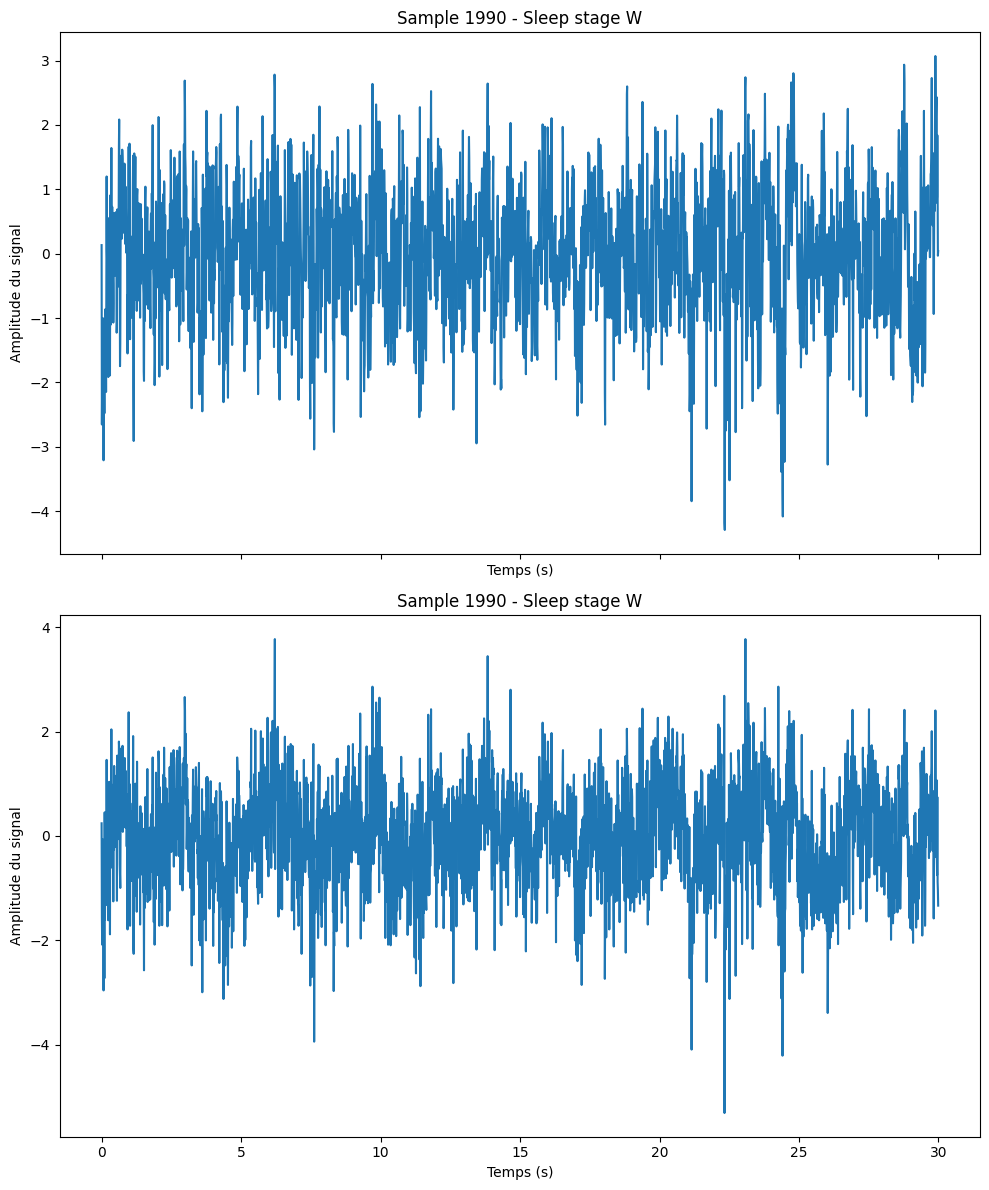

In [11]:

unique_labels = df['label'].unique()
unique_labels = unique_labels[0:5]

random_indices = [df[df['label'] == label].sample().index[0] for label in unique_labels]
sequence = []
sequence.append(df.iloc[random_indices[0], :-1].values)
sequence.append(df_sans_highPass.iloc[random_indices[0], :-1].values)

# Créer une figure avec 5 sous-plots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Labels correspondants à chaque classe
class_labels = ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R']
   
for i in range(2):
    time_vector = np.arange(0, 30, 0.01)
    axes[i].plot(time_vector, sequence[i])
    axes[i].set_title(f'Sample {random_indices[0]} - {class_labels[0]}')
    axes[i].set_xlabel('Temps (s)')
    axes[i].set_ylabel('Amplitude du signal')

# Ajuster l'espace entre les sous-plots pour éviter les chevauchements
plt.tight_layout()

# Afficher la figure
plt.show()


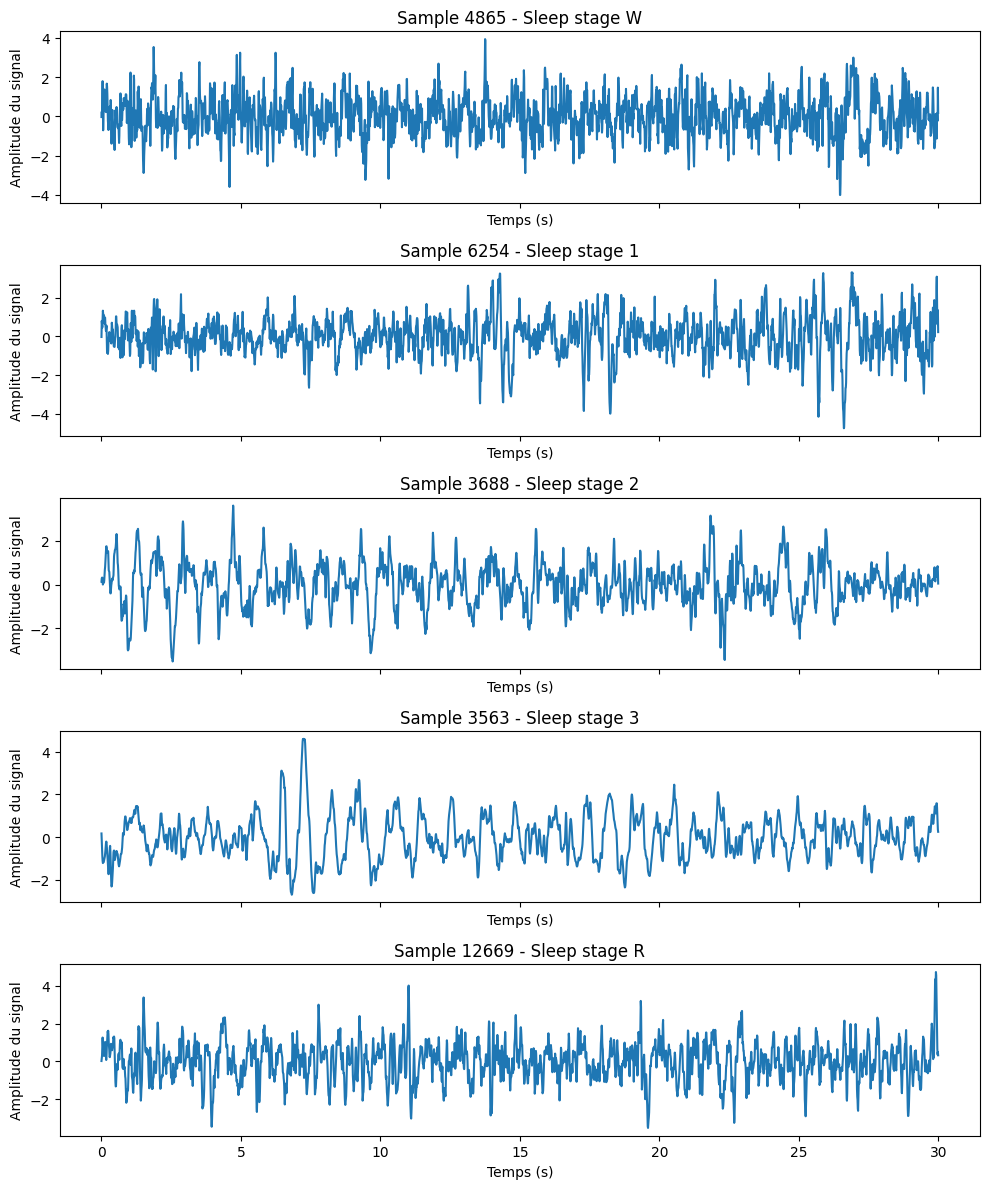

In [10]:
unique_labels = df['label'].unique()
unique_labels = unique_labels[0:5]

random_indices = [df[df['label'] == label].sample().index[0] for label in unique_labels]

# Créer une figure avec 5 sous-plots
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Labels correspondants à chaque classe
class_labels = ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R']

# Parcourir les sous-plots et tracer les séquences
for i, index in enumerate(random_indices):
    sequence = df.iloc[index, :-1].values
    time_vector = np.arange(0, 30, 0.01)
    axes[i].plot(time_vector, sequence)
    axes[i].set_title(f'Sample {index} - {class_labels[i]}')
    axes[i].set_xlabel('Temps (s)')
    axes[i].set_ylabel('Amplitude du signal')

# Ajuster l'espace entre les sous-plots pour éviter les chevauchements
plt.tight_layout()

# Afficher la figure
plt.show()


Data Tuning and Splitting

In [16]:
# Removing Sleep Stage ? and Movement Time (label == 5)
selected_rows=df.loc[df['label'] != 5.0]
selected_rows.shape, selected_rows.iloc[0:25, -1]

# Splitting Data (70% training, 20% test, 10% validation)
database_features = selected_rows.iloc[:, :-1]
database_labels = selected_rows.iloc[:, -1]

train_set, test_set, train_labels, test_labels = train_test_split(database_features, database_labels, test_size=0.3, random_state=42)
val_set, test_set, val_labels, test_labels = train_test_split(test_set, test_labels, test_size=(2/3), random_state=42)

print(f'train shape is {train_set.shape}, test shape is {test_set.shape} and val shape is {val_set.shape}')

# Converting labels with one hot encoding (turning class vector labels into binary class matrix )
train_labels_one_hot = to_categorical(train_labels)
val_labels_one_hot = to_categorical(val_labels)
test_labels_one_hot = to_categorical(test_labels)
train_labels_one_hot.shape, train_set.shape, val_labels_one_hot.shape, train_labels[0:25] #to verify it is shuffled


train shape is (9753, 3000), test shape is (2787, 3000) and val shape is (1393, 3000)


((9753, 5),
 (9753, 3000),
 (1393, 5),
 10158    0.0
 909      0.0
 9432     4.0
 3399     0.0
 496      0.0
 8699     0.0
 9276     2.0
 10314    0.0
 4623     0.0
 11899    1.0
 3470     0.0
 12226    2.0
 9294     2.0
 1195     2.0
 5351     0.0
 1423     2.0
 4760     0.0
 256      0.0
 11744    0.0
 8445     0.0
 288      0.0
 5460     0.0
 9384     4.0
 6573     2.0
 10235    0.0
 Name: label, dtype: float64)

Data Exploration 

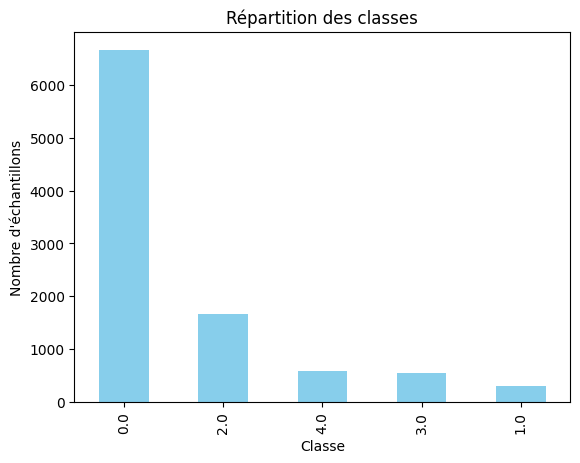

In [17]:
# Compter le nombre d'échantillons par classe

class_counts = train_labels.value_counts()

# Tracer le diagramme en barres
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.title('Répartition des classes')
plt.show()


In [18]:
# Vérifiez si un GPU est disponible

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


Model Building

In [19]:
from keras.optimizers import RMSprop, Adam
from keras.layers import Input
from keras.callbacks import EarlyStopping
from keras.models import Model

# Architecture d'un réseau à couche convolutionnelles avec peu de couches
def cnn_Broshra(input):
    # input layer
    x = Input(shape=input, name='input_var') 

    # hidden layers
    network = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(x) 
    network = keras.layers.MaxPooling1D(pool_size=2)(network)
    network = keras.layers.Flatten()(network)
    network = keras.layers.Dense(50, activation='relu')(network)

    # output layer
    output = keras.layers.Dense(5, activation='softmax')(network)  # 5 output classes
    
    return Model(inputs=x, outputs=output)

# Add early stopping
callback = EarlyStopping(monitor='val_loss', patience=3)

input = (train_set.shape[1], 1)
model_lab=cnn_Broshra(input)
model_lab.summary()

# Compile the model
model_lab.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_var (InputLayer)      [(None, 3000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 2998, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1499, 64)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 95936)             0         
                                                                 
 dense (Dense)               (None, 50)                4796850   
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                           

Model Tuning - Class weighting

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculer les poids de classe
class_weights = compute_class_weight('balanced',classes=np.unique(train_labels), y=train_labels)

# Créer un dictionnaire de poids de classe
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.29261926192619264,
 1: 6.6801369863013695,
 2: 1.168723786698622,
 3: 3.5988929889298893,
 4: 3.3400684931506848}

Model Training - With Early Stopping

In [21]:
# Reshape des données pour s'adapter au modèle Conv1D
train_set_reshaped = train_set.values.reshape((train_set.shape[0], train_set.shape[1], 1))
val_set_reshaped = val_set.values.reshape((val_set.shape[0], val_set.shape[1], 1))
test_set_reshaped = test_set.values.reshape((test_set.shape[0], test_set.shape[1], 1))

# Entraîner le modèle
history = model_lab.fit(train_set, train_labels_one_hot, epochs=50, batch_size=32,
                    validation_data=(val_set, val_labels_one_hot), class_weight=class_weight_dict, callbacks=[callback])


Epoch 1/50


305/305 [==============================] - 22s 69ms/step - loss: 1.6283 - accuracy: 0.6841 - val_loss: 0.9120 - val_accuracy: 0.5887
Epoch 2/50
305/305 [==============================] - 21s 69ms/step - loss: 0.8206 - accuracy: 0.7674 - val_loss: 0.7806 - val_accuracy: 0.6719
Epoch 3/50
305/305 [==============================] - 21s 70ms/step - loss: 0.5981 - accuracy: 0.8342 - val_loss: 0.5829 - val_accuracy: 0.8011
Epoch 4/50
305/305 [==============================] - 21s 68ms/step - loss: 0.4490 - accuracy: 0.8758 - val_loss: 0.5482 - val_accuracy: 0.7933
Epoch 5/50
305/305 [==============================] - 21s 70ms/step - loss: 0.3307 - accuracy: 0.9037 - val_loss: 0.5166 - val_accuracy: 0.8485
Epoch 6/50
305/305 [==============================] - 21s 69ms/step - loss: 0.2395 - accuracy: 0.9248 - val_loss: 0.5828 - val_accuracy: 0.8313
Epoch 7/50
305/305 [==============================] - 20s 67ms/step - loss: 0.1715 - accuracy: 0.9434 - val_loss: 0.6036 - val_accurac

Model Evaluation - Basic metrics

In [22]:
test_loss, test_accuracy = model_lab.evaluate(test_set_reshaped, test_labels_one_hot)
print(f"Test Accuracy: {test_accuracy}")

88/88 [==============================] - 1s 14ms/step - loss: 0.5373 - accuracy: 0.8644
Test Accuracy: 0.8643702864646912


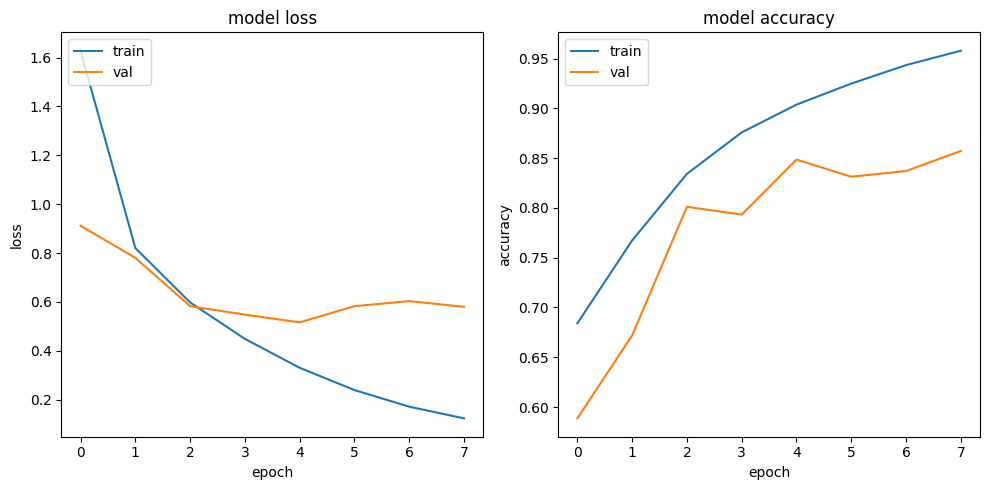

In [23]:
# Créer un subplot avec 2 lignes et 1 colonne
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='upper left')

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('model accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()


Model Evaluation - Deeper Analysis with more accurate metrics

88/88 [==============================] - 1s 15ms/step


C:\Users\theod\AppData\Local\Temp\ipykernel_3384\3674089850.py:17: RuntimeWarning: divide by zero encountered in divide
  cmn_F1 = 2*(1/((1/cmn_precision)+(1/cmn_recall)))


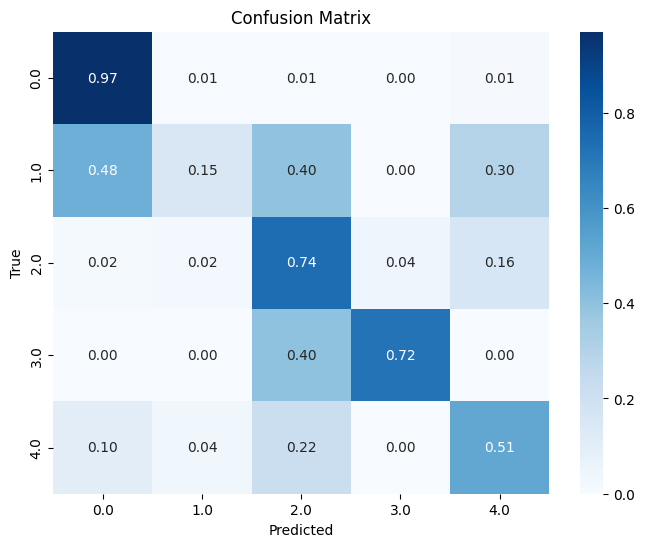

In [26]:
import seaborn as sns

# Assuming you have predictions and true labels as one-hot encoded arrays
y_pred = model_lab.predict(test_set)

# Decode one-hot encoded predictions and ground truth labels
y_pred_decoded = np.argmax(y_pred, axis=1)
y_true_decoded = np.argmax(test_labels_one_hot, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_decoded, y_pred_decoded)#, normalize='true')


cmn_recall = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] #Recall, TP / TP+FN where FN are on axis=1 columns
cmn_precision = conf_matrix.astype('float') / conf_matrix.sum(axis=0)[:, np.newaxis] #precision, TP / TP+FP where FP are on axis=0 lines

cmn_F1 = 2*(1/((1/cmn_precision)+(1/cmn_recall)))

# Define class labels for visualization (e.g., class_labels = ['0.0', '1.0', '2.0'...])
class_labels = selected_rows['label'].unique()

class_labels = [str(label) for label in class_labels]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cmn_F1, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()